In [1]:
# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from xgboost import XGBClassifier

# Scikit-learn imports
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

First few rows of the dataset:
         Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  

Dataset dimensions (rows, columns):
(2713, 7)

Summary statistics:
               Open          High           Low         Close     Adj Close  \
count   2713.000000   2713.000000   2713.000000   2713.000000   2713.000000   
mean   11311.041069  11614.292482  10975.555057  11323.914637  11323.914637   
std    16106.428891  16537.390649  15608.572560  16110.365010  16110.365010   
min      176.897003    211.731003    1

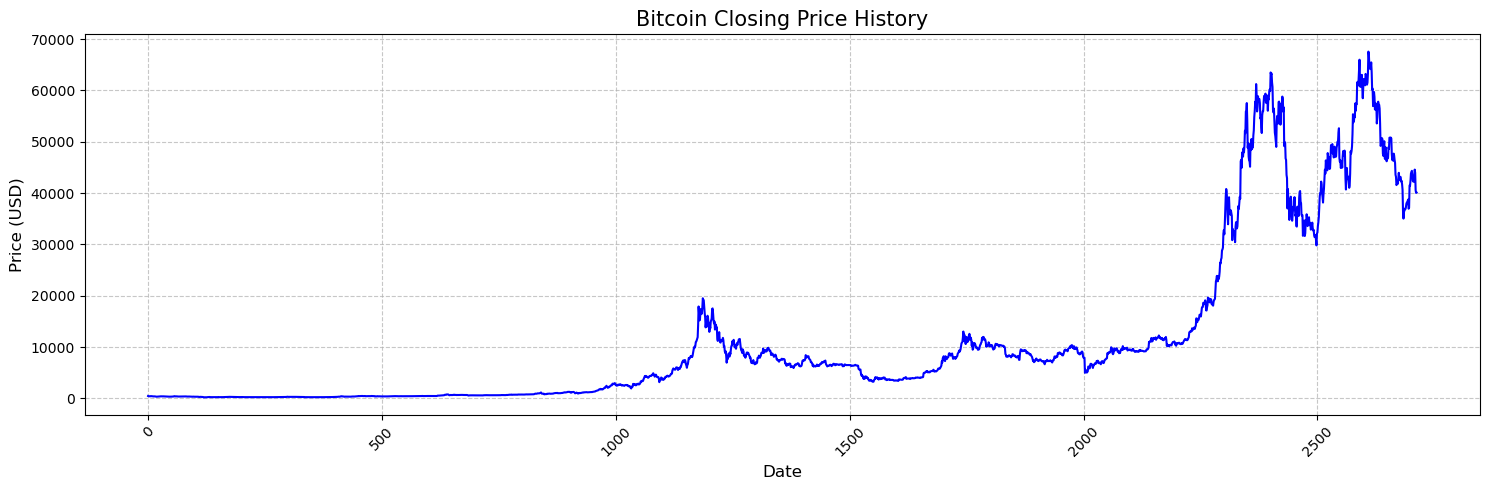

In [2]:
# Load and read the Bitcoin data
df = pd.read_csv('bitcoin.csv')

# Display basic information about the dataset
print("First few rows of the dataset:")
print(df.head())

print("\nDataset dimensions (rows, columns):")
print(df.shape)

print("\nSummary statistics:")
print(df.describe())

# Visualize Bitcoin closing prices over time
plt.figure(figsize=(15, 5))
plt.plot(df['Close'], color='blue', linewidth=1.5)
plt.title('Bitcoin Closing Price History', fontsize=15)
plt.ylabel('Price (USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

Checking for identical values in Close and Adj Close:
Identical rows: (2713, 7)
Total rows: (2713, 7)

Missing values in each column:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


C:\Users\brend\AppData\Local\Temp\ipykernel_54072\1727320469.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df[col], hist=True, kde=True)
C:\Users\brend\AppData\Local\Temp\ipykernel_54072\1727320469.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df[col], hist=True, kde=True)
C:\Users\b

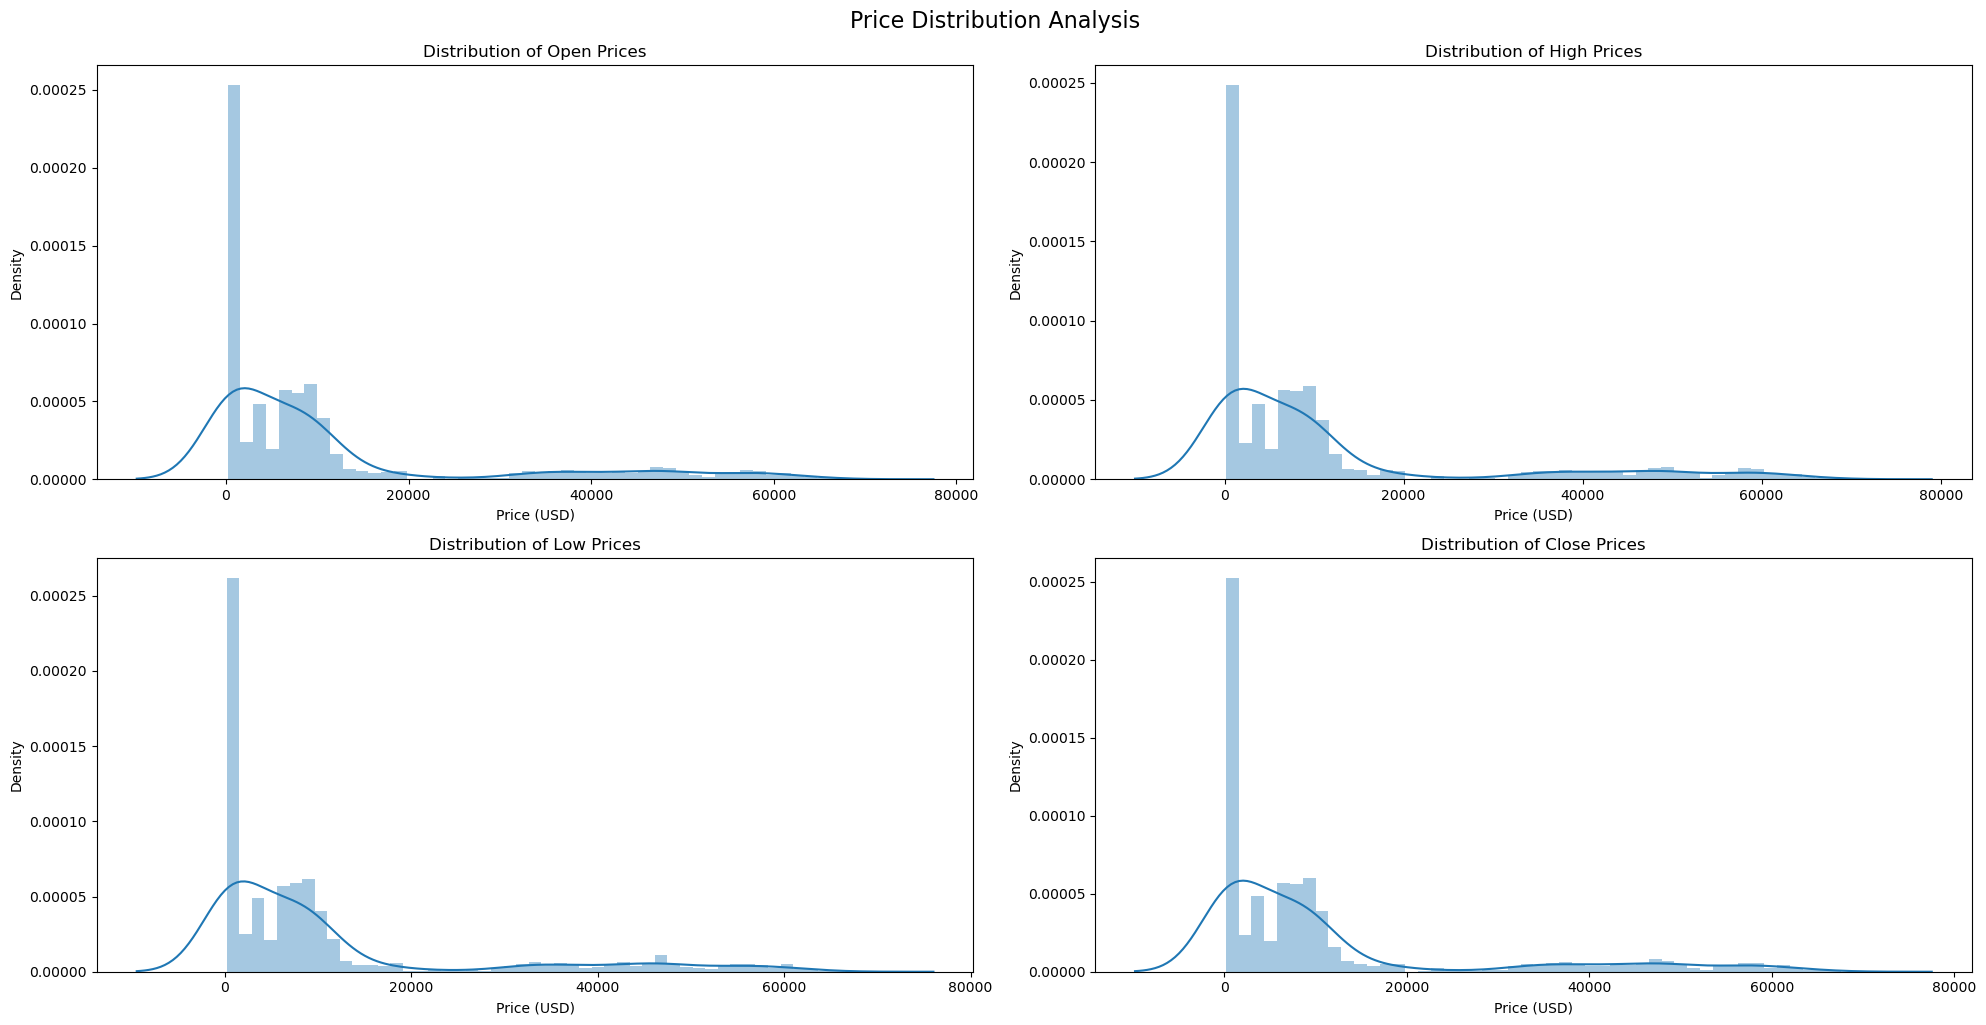

In [3]:
# Check if 'Close' and 'Adj Close' are identical and compare shapes
print("Checking for identical values in Close and Adj Close:")
identical_rows = df[df['Close'] == df['Adj Close']].shape
total_rows = df.shape
print(f"Identical rows: {identical_rows}")
print(f"Total rows: {total_rows}")

# Remove redundant 'Adj Close' column
df = df.drop(['Adj Close'], axis=1)

# Check for missing values in the dataset
print("\nMissing values in each column:")
print(df.isnull().sum())

# Define price-related features for analysis
features = ['Open', 'High', 'Low', 'Close']

# Create distribution plots for price features
plt.figure(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sb.distplot(df[col], hist=True, kde=True)
    plt.title(f'Distribution of {col} Prices', fontsize=12)
    plt.xlabel('Price (USD)', fontsize=10)
    plt.ylabel('Density', fontsize=10)

plt.tight_layout()  # Prevent subplot overlap
plt.suptitle('Price Distribution Analysis', fontsize=16, y=1.02)
plt.show()

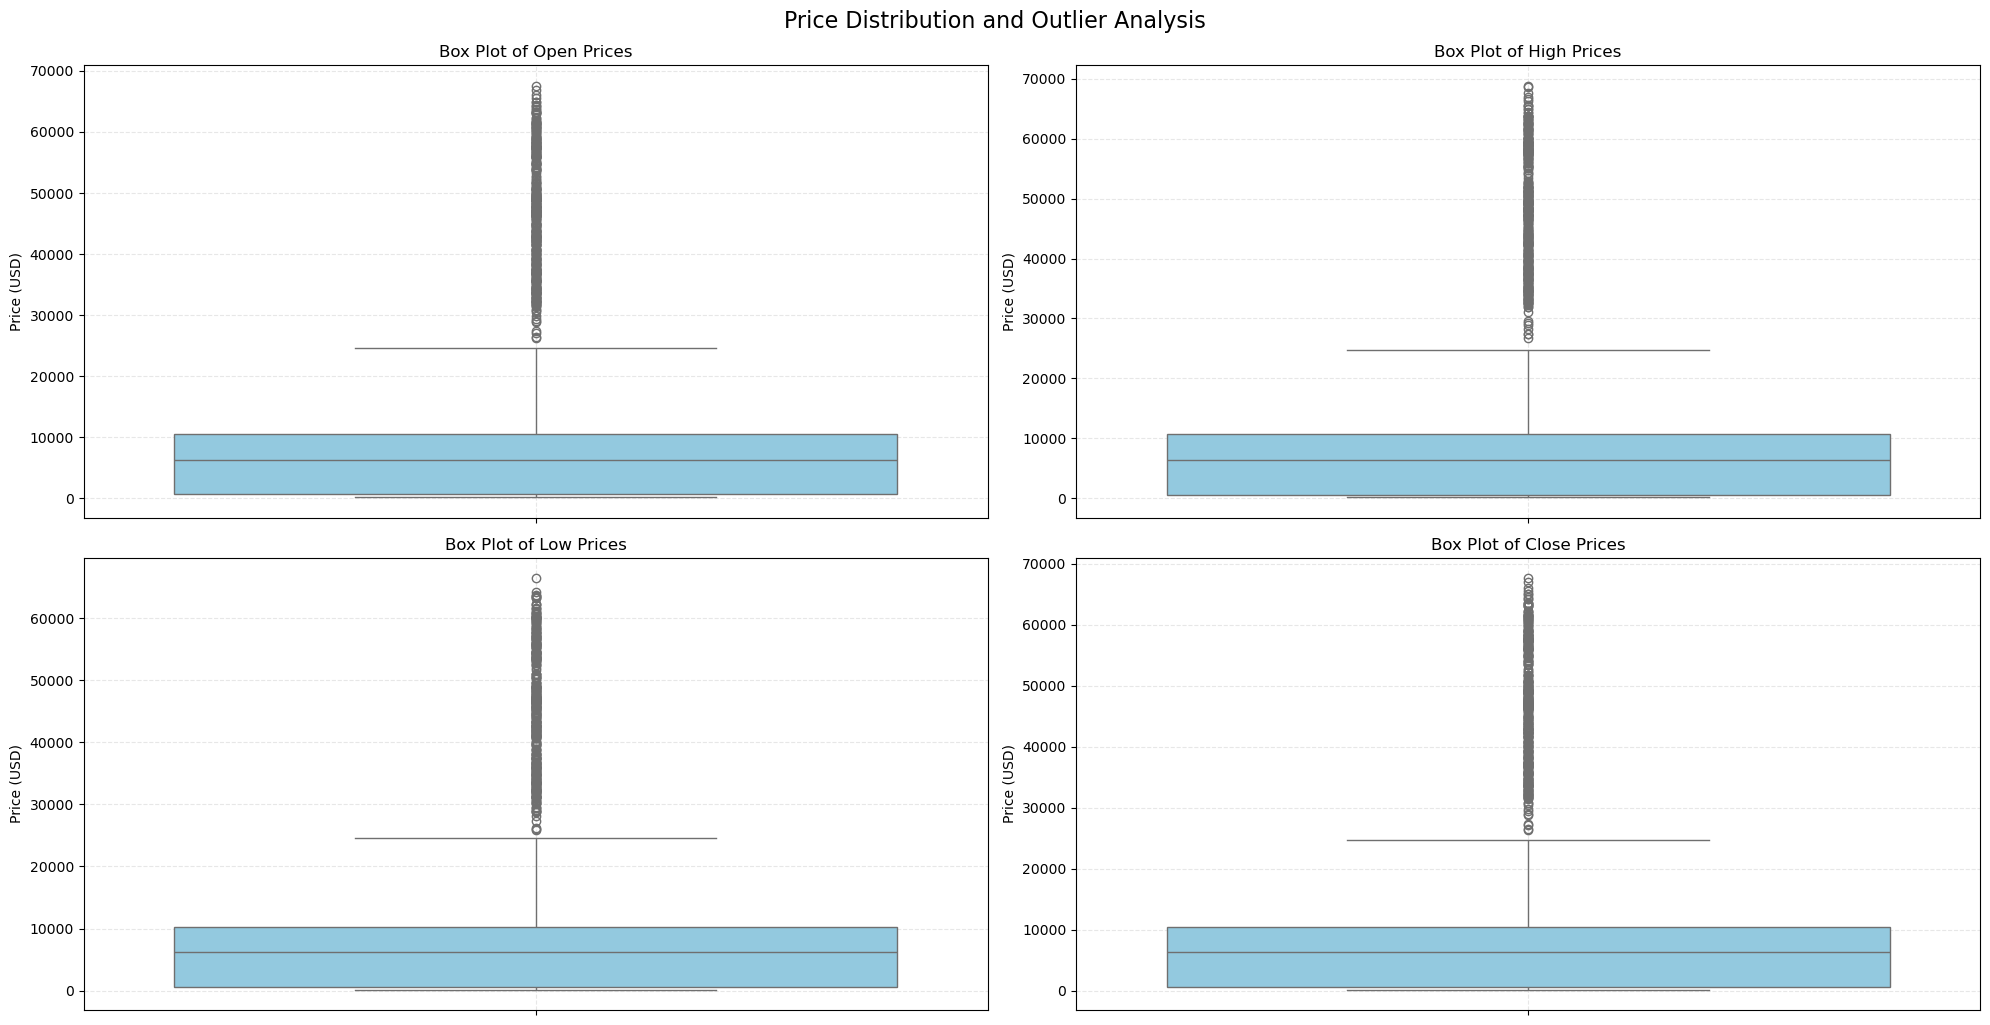

In [4]:
# Create box plots to visualize price distributions and identify outliers
plt.figure(figsize=(20, 10))

# Create subplots for each price feature
for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sb.boxplot(y=df[col], color='skyblue')
    plt.title(f'Box Plot of {col} Prices', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.3)

# Adjust layout and add overall title    
plt.tight_layout()
plt.suptitle('Price Distribution and Outlier Analysis', fontsize=16, y=1.02)
plt.show()

In [5]:
# Define features and target variables
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

# Initialize and apply StandardScaler for feature normalization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data chronologically (70-30 split)
split_point = len(features) // 7  # Calculate split index for 70% of data

# Create training and validation sets
X_train = features_scaled[:split_point]
X_valid = features_scaled[split_point:]
Y_train = target[:split_point]
Y_valid = target[split_point:]

# Verify split sizes
print(f"Training set size: {len(X_train)} ({(len(X_train)/len(features))*100:.1f}%)")
print(f"Validation set size: {len(X_valid)} ({(len(X_valid)/len(features))*100:.1f}%)")

KeyError: "None of [Index(['open-close', 'low-high', 'is_quarter_end'], dtype='object')] are in the [columns]"

In [6]:
# Define models for comparison
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(kernel='poly', probability=True),
    'XGBoost': XGBClassifier()
}

# Train models and evaluate performance
print("Model Performance Evaluation\n" + "="*25)

for name, model in models.items():
    # Train the model
    model.fit(X_train, Y_train)
    
    # Calculate probabilities for ROC AUC
    train_probs = model.predict_proba(X_train)[:, 1]
    valid_probs = model.predict_proba(X_valid)[:, 1]
    
    # Calculate and display metrics
    train_auc = metrics.roc_auc_score(Y_train, train_probs)
    valid_auc = metrics.roc_auc_score(Y_valid, valid_probs)
    
    print(f"\n{name}:")
    print(f"Training ROC AUC   : {train_auc:.4f}")
    print(f"Validation ROC AUC : {valid_auc:.4f}")

# Visualize confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    models['Logistic Regression'],
    X_valid,
    Y_valid,
    cmap='Blues'
)
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

Model Performance Evaluation


NameError: name 'X_train' is not defined